<a href="https://colab.research.google.com/github/DamaKubu/Fizikos-bakalauras/blob/main/HurstSelfConsistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trumpas įvadas:

notebookas skirtas testuoti FBM generavimo metodų, bei metodų savi-patikimumą Hursto nustatymui.

Noriu generuoti du grafikus.
Vienas sudarytas iš daug kelių generavimo algoritmų, bei atpažinimo algoritmų.

Taip pat, kaip priklauso erroras nuo realizacijos ilgio.




----------------------------------


Manau galiu biški naudingesnius rezultatus gauti.

Pirmas dalykas, norėčiau skirtingų ilgių ir aiškaus bibliotekų implementacijų.

- kokio ilgio realizacijos tiksliai kuriamas ir aptinkamas hurstas.
- kiek realizacijų?, jei tik šešis padarau, tai why not 9?
- kaip priklauso nuo skirtingo ilgio
- padaryt vieną programą funkciją ir ją runnint.
- galiu daugiau algoritmų katz įdėt ir kitus!

- galiu cholesky, hosking, ir dar kitus įdėti.

#RUN this, pips **Imports** and functions

In [2]:
#Pips

!pip install MFDFA
!pip install hurst
!pip install fbm
!pip install hurst

In [3]:
## imports

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import time
from hurst import compute_Hc


from fbm import FBM
import math
from scipy import stats

# Imports
from MFDFA import MFDFA
from MFDFA import fgn
# where this second library is to generate fractional Gaussian noises


from hurst import compute_Hc, random_walk


plt.rcParams["figure.figsize"] = (5,5)
## constants and shit

from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import stats
# Two-sided inverse Students t-distribution
from scipy.stats import t
# plt.figure()
# plt.subplot(311) #subplot(nrows, ncols, index, **kwargs)
# plt.scatter(x, y, s=0.0001)
# plt.subplot(312)
def plotLinearFit(x,y,xlabel='xlabel',ylabel='ylabel',plot=True,s=0.05):
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    res = stats.linregress(x, y)
    if plot == True:
        Nuokrypis = f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f} \n intercept (95%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}\n using Students two-sided t-distribution"
        plt.figure(figsize=(10,5))
        plt.scatter(x,y,s,label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label=Nuokrypis)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    return res.slope

In [4]:
#norėtusi padaryt su klase šitą, bet c is my style

#functions to find Hurst from realisation

def myMSA(generation_method, N = 100, hh_set=[0.2,0.5,0.8]):
    tt = np.linspace(START_N, N, N)

    hh_extrapolated = [[]]

    #print(f"h_IN : h_OUT")
    for h_set in hh_set:

        f = FBM(n=N, hurst=h_set, length=N, method= generation_method )

        h_extrapolated = []

        Tries = 1
        for q in range(TRIES):
            xxx = [[]]

            for _ in range(xx_populiation):
                xxx.append(f.fbm()[1:])

            xxx = np.array(xxx[1:])**2
            ## susumuojam(ner skirtuma ar tsg vidurkis) palei 0 ašį.
            summed = np.sum(xxx, 0)

            h_out = plotLinearFit(np.log(tt),
                            np.log(summed),
                            xlabel='t',
                            ylabel='log(sum(x^2))',
                            plot=False) / 2

            h_extrapolated.append(h_out)
            #print(f'{h_set:2.2f}:{h_out:2.2f}')

        hh_extrapolated.append(h_extrapolated)

    return np.array(hh_extrapolated[1:]).flatten()


def myMFDFA(generation_method, N = 100, hh_set=[0.2,0.5,0.8]):

    #hh_set = #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
    # Notice these must be ints, since these will segment
    # the data into chucks of lag size

    # Select the power q
    q = 2

    # The order of the polynomial fitting
    order = 1

    h_out =[]
    for h in hh_set:
        f = FBM(n=N, hurst=h, length=N, method=generation_method)
        y = f.fbm()[1:]
        # Obtain the (MF)DFA as
        lag, dfa = MFDFA(y, lag = lag, q = q, order = order)
        # And now we need to fit the line to find the slope. Don't
        # forget that since you are plotting in a double logarithmic
        # scales, you need to fit the logs of the results
        H_hat = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0]

        # Now what you should obtain is: slope = H + 1
        #print('Estimated H = '+'{:.3f}'.format(H_hat[0]))
        h_out.append(H_hat[0]-1)

    return h_out


def myhiguchi(generation_method, N = 100, hh_set=[0.2,0.5,0.8]): #Higuchi FD
    #higuchi FD algorithm:
    #from https://github.com/gilestrolab/pyrem/blob/master/src/pyrem/univariate.py
    # ką reiškia k_max??
    def higuchi1(a, k_max = 10):
        L = []
        x = []
        N = len(a)

        for k in range(1,k_max):
            Lk = 0
            for m in range(0,k):
                #we pregenerate all idxs
                idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
                Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
                Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
                Lk += Lmk

            L.append(np.log(Lk/(m+1)))
            x.append([np.log(1.0/ k), 1])

        (p, r1, r2, s)=np.linalg.lstsq(x, L,rcond=-1)
        return p[0]
    h_out = []
    #print(f"h_IN : h_OUT")
    for h in hh_set:

        #f2 = FractionalBrownianMotion(hurst=h, t=N)
        #y = f2.sample(N)[1:]
        f = FBM(n=N, hurst=h, length=N, method='daviesharte')
        y = f.fbm()[1:]
        hout = 2-higuchi1(y)

        #print(f'{h:2.2f}:{hout:2.2f}')
        h_out.append(hout)

    return h_out


def myRC(generation_method, N = 100, hh_set=[0.2,0.5,0.8]):
    h_out =[]
    for h in hh_set:
        f = FBM(n=N, hurst=h, length=N, method=generation_method)
        y = f.fbm()[1:]

        # Evaluate Hurst equation
        H, c, data = compute_Hc(y, kind='random_walk', simplified=False)
        h_out.append(H)

    return h_out







#funkcija kuria pakvieciu kitas funkcijas naudodamas directory
#def callOut()

#functions to generate fbm with Hurst

# de code

In [ ]:
#debuging stuff
!pip install ipdb
import ipdb
%pdb on

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00


In [5]:
#constants GLOBAL

START_N = 1
N = 100
xx_populiation = 10 #keik skirtingu xx
tt = np.linspace(START_N, N, N)

TRIES = 1

hh_set = np.linspace(0.01, 0.99, 30)


/usr/local/lib/python3.10/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


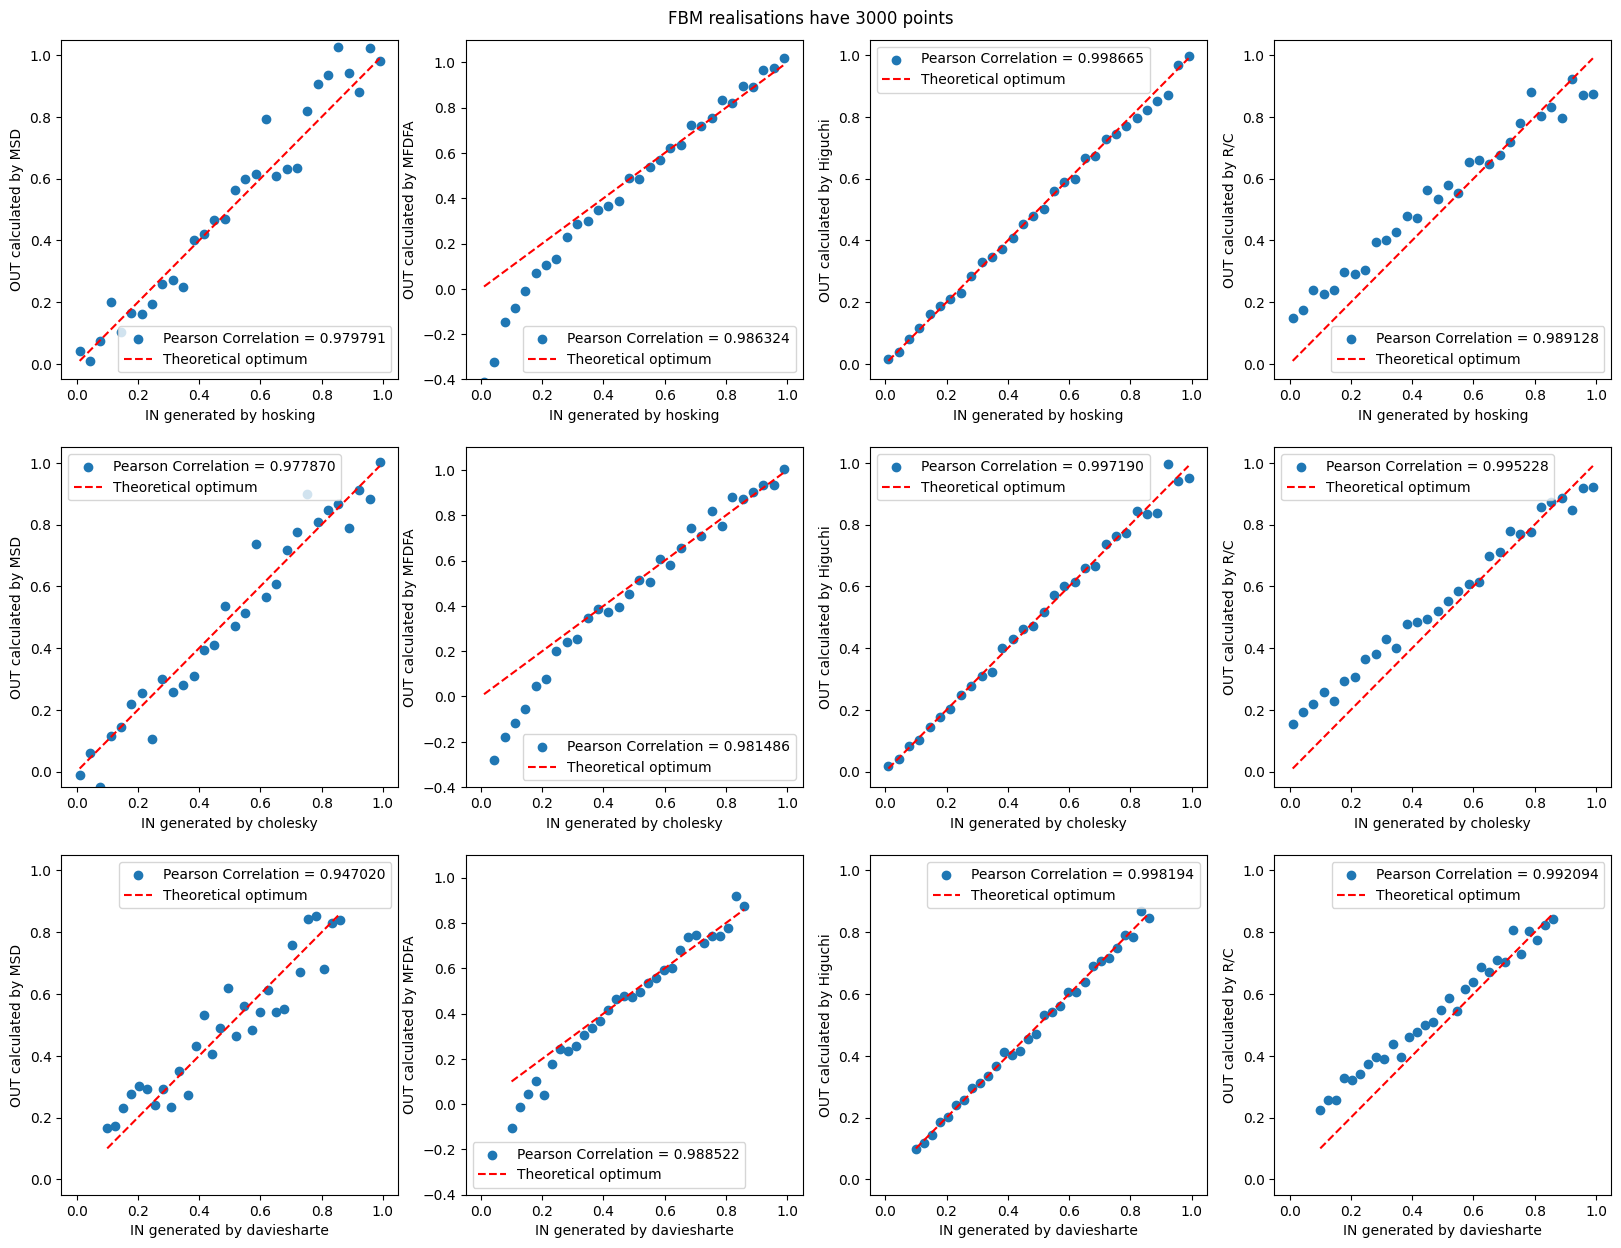

In [24]:
TRIES = 1 #tries multiple time to determine error

#noriu dar Katz idėt ir dar kelis bent!
OutUsing = {'MSD':myMSA, 'MFDFA':myMFDFA, 'Higuchi': myhiguchi, 'R/C': myRC}

generation_methods = ['hosking', 'cholesky','daviesharte']
N = 2000




fig, ax = plt.subplots(3,4,figsize=(5*4,5*3))
fig.suptitle(f'FBM realisations have {N} points', y = 0.9)


for j, generation_method in enumerate(generation_methods):
    for i, out in enumerate(OutUsing):
        if generation_method == 'daviesharte':
            hh_set = np.linspace(0.1, 0.86, 30) # without very small and big values
        else:
            hh_set = np.linspace(0.01, 0.99, 30)

        h_out = OutUsing[out](generation_method, N = N, hh_set=hh_set)
        ax[j][i].set_xlim(-0.05,1.05)
        ax[j][i].set_ylim(-0.05,1.05)
        ax[j][i].scatter(hh_set, h_out, label=f'Pearson Correlation = {np.corrcoef(hh_set, h_out)[0][1]:3.6f}')
        ax[j][i].plot(hh_set, hh_set, 'r--', label = 'Theoretical optimum')
        ax[j][i].set_ylabel(f'OUT calculated by {out}')
        ax[j][i].set_xlabel(f'IN generated by {generation_method}')
        ax[j][i].legend()
        if i == 1:
            ax[j][i].set_ylim(-0.4,1.1)



fig.savefig('Results2.png', format='png', dpi=700)


#ax.set_title(' MSA')
#plt.grid()

In [ ]:
globals().clear() #clean every variable

In [ ]:
import numpy as np
#chatGPT same code rewritten in class

class HurstCalculator:
    def __init__(self, generation_method, N=100, hh_set=[0.2, 0.5, 0.8]):
        self.generation_method = generation_method
        self.N = N
        self.hh_set = hh_set

    def myMSA(self):
        tt = np.linspace(1, self.N, self.N)
        hh_extrapolated = []

        for h_set in self.hh_set:
            f = FBM(n=self.N, hurst=h_set, length=self.N, method=self.generation_method)
            h_extrapolated = []

            for _ in range(1):  # Replace 1 with the number of tries you need
                trajectories = [f.fbm()[1:] for _ in range(10)]  # Replace 10 with your population size
                squared_trajectories = np.array(trajectories) ** 2
                summed = np.sum(squared_trajectories, axis=0)

                # Linear fit of log-log plot
                h_out = np.polyfit(np.log(tt), np.log(summed), 1)[0] / 2
                h_extrapolated.append(h_out)

            hh_extrapolated.append(h_extrapolated)

        return np.array(hh_extrapolated).flatten()

    def myMFDFA(self):
        lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
        q = 2
        order = 1
        h_out = []

        for h in self.hh_set:
            f = FBM(n=self.N, hurst=h, length=self.N, method=self.generation_method)
            y = f.fbm()[1:]
            lag, dfa = MFDFA(y, lag=lag, q=q, order=order)
            H_hat = np.polyfit(np.log(lag)[4:20], np.log(dfa[4:20]), 1)[0]
            h_out.append(H_hat - 1)

        return h_out

    def myHiguchi(self):
            #higuchi FD algorithm:
        #from https://github.com/gilestrolab/pyrem/blob/master/src/pyrem/univariate.py
        # ką reiškia k_max??
        def higuchi1(a, k_max = 10):
            L = []
            x = []
            N = len(a)

            for k in range(1,k_max):
                Lk = 0
                for m in range(0,k):
                    #we pregenerate all idxs
                    idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
                    Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
                    Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
                    Lk += Lmk

                L.append(np.log(Lk/(m+1)))
                x.append([np.log(1.0/ k), 1])

            (p, r1, r2, s)=np.linalg.lstsq(x, L,rcond=-1)
            return p[0]
        h_out = []
        for h in self.hh_set:
            f = FBM(n=self.N, hurst=h, length=self.N, method=self.generation_method)
            y = f.fbm()[1:]
            hout = 2 - higuchi1(y, k_max=10)
            h_out.append(hout)
        return h_out

    def myRC(self):
        h_out = []
        for h in self.hh_set:
            f = FBM(n=self.N, hurst=h, length=self.N, method=self.generation_method)
            y = f.fbm()
            H, c, data = compute_Hc(y, kind='random_walk', simplified=False)
            h_out.append(H)
        return h_out

# Example of creating and using the HurstCalculator class
hurst_calculator = HurstCalculator(generation_method='daviesharte')
results_msa = hurst_calculator.myMSA()
results_mfdfa = hurst_calculator.myMFDFA()
results_higuchi = hurst_calculator.myHiguchi()
results_rc = hurst_calculator.myRC()


In [ ]:
#noriu dar Katz idėt ir dar kelis bent!
OutUsing = {'MSA':myMSA, 'MFDFA':myMFDFA, 'Higuchi': myhiguchi, 'R/C': myRC}

generation_methods = ['hosking', 'cholesky','daviesharte']




fig, ax = plt.subplots(3,4,figsize=(6*4,6*3))
fig.suptitle(f'FBM realisations have {N} points', y = 0.9)


for j, generation_method in enumerate(generation_methods):
    for i,out in enumerate(OutUsing):
        h_out = OutUsing[out](generation_method, N = N, hh_set=hh_set)
        Pearson_Correlation = {np.corrcoef(hh_set, h_out)[0][1]:3.6f}

array([0.13704449, 0.43344737, 0.84037863])

0 has completed


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1 has completed


<ipython-input-4-2b5c4bbc1008>:91: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk/(m+1)))


2 has completed
3 has completed


ValueError: x and y must be the same size

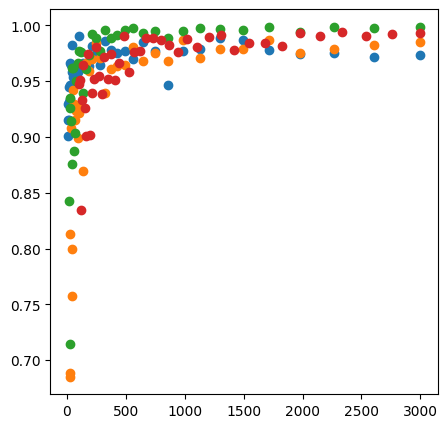

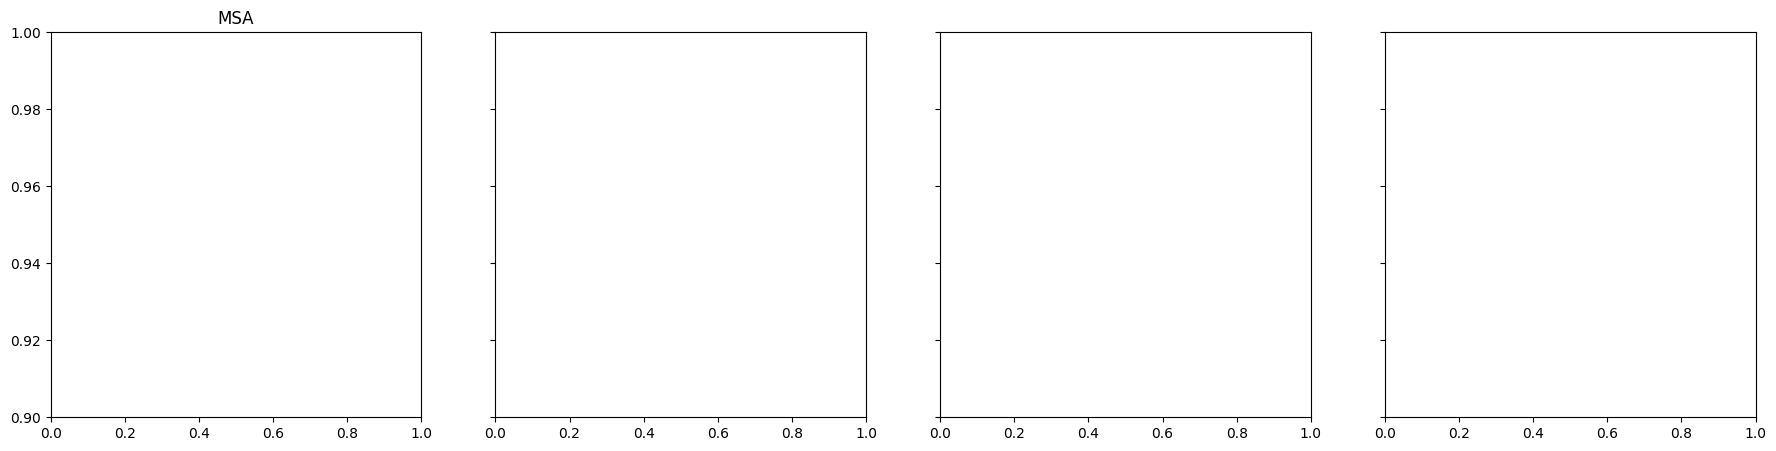

In [17]:
#noriu dar Katz idėt ir dar kelis bent!
OutUsing = {'MSA':myMSA, 'MFDFA':myMFDFA, 'Higuchi': myhiguchi, 'R/C': myRC}

generation_methods = ['hosking', 'cholesky','daviesharte']
TRIES = 1


hh_set = np.linspace(0.01, 0.99, 16)
#out = 'Higuchi'
generation_method='daviesharte'

# Generate log-distributed data
start = np.log10(10)    # Start of the log scale (log10 of 10)
start2 = np.log10(100)
stop = np.log10(3000)   # End of the log scale (log10 of 3000)
num_points = 42        # Number of data points

#log_distributed_data = np.logspace(start, stop, num=num_points, dtype=int)

#print(log_distributed_data)

Presults = [[]]

for i, out in enumerate(OutUsing):

#fig.suptitle(f'FBM realisations have {N} points', y = 0.95)

    #NN = np.linspace(10, 3000, 30, dtype = np.int64) linear

    if out == 'R/C':
        NN = np.logspace(start2, stop, num=num_points, dtype=int)
    else:
        NN = np.logspace(start, stop, num=num_points, dtype=int)

    Pearson_Correlations = []
    for n in NN:
        h_out = OutUsing[out](generation_method, N = int(n), hh_set=hh_set)
        Pearson_Correlations.append(np.corrcoef(hh_set, h_out)[0][1])

    Presults.append(Pearson_Correlations)
    print(f'{i} has completed')
    plt.scatter(NN, Pearson_Correlations)



fig, ax = plt.subplots(1,4,figsize=(22,5),sharey=True)

for i, out in enumerate(OutUsing):
    if out == 'R/C':
        NN = np.logspace(start2, stop, num=num_points, dtype=int)
    else:
        NN = np.logspace(start, stop, num=num_points, dtype=int)
    ax[i].set_ylim(0.9,1.0)
    ax[i].set_title(f'{out}')
    ax[i].scatter(NN, Presults[i], s=8, alpha = 0.67)
    ax[i].set_xlabel(f'Length of realisation')
    ax[i].set_ylabel('Corr($H_{in}$, $H_{out}$)')
    ax[i].grid()


fig.savefig('Pearson.png', format='png', dpi=600)


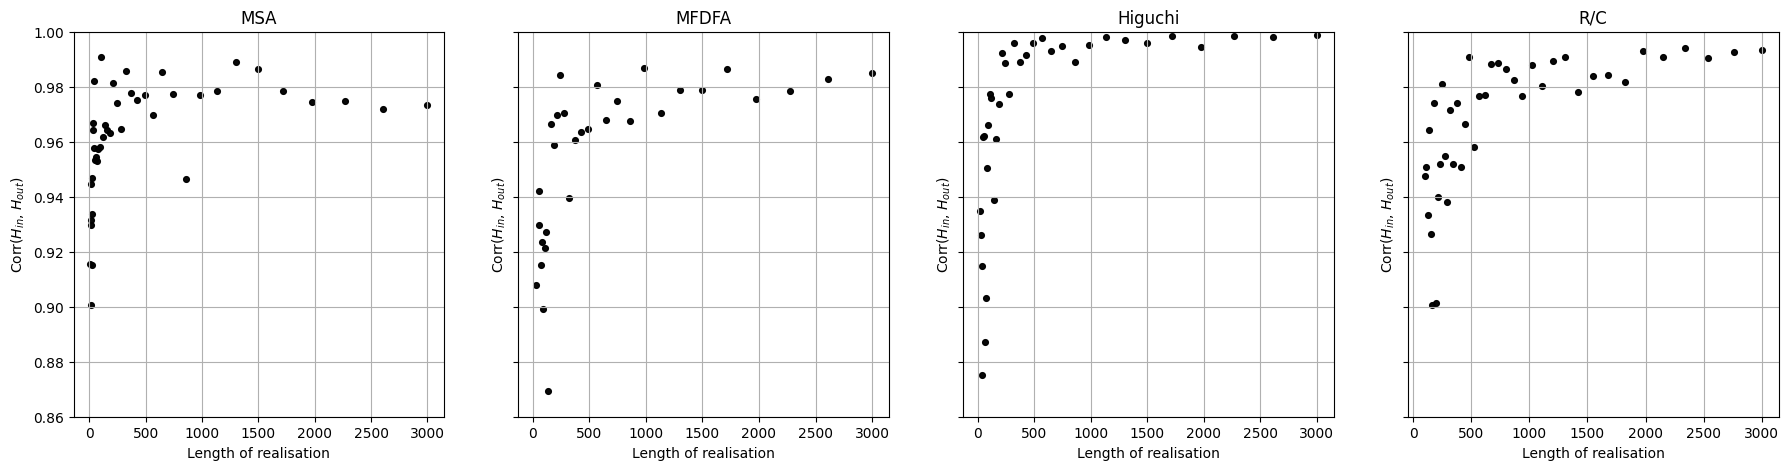

In [27]:
fig, ax = plt.subplots(1,4,figsize=(22,5),sharey=True)

#Presults = Presults[1:]
for i, out in enumerate(OutUsing):
    if out == 'R/C':
        NN = np.logspace(start2, stop, num=num_points, dtype=int)
    else:
        NN = np.logspace(start, stop, num=num_points, dtype=int)
    ax[i].set_ylim(0.86,1.0)
    ax[i].set_title(f'{out}')
    ax[i].scatter(NN, Presults[i], s=17, alpha = 0.97, c='black')
    ax[i].set_xlabel(f'Length of realisation')
    ax[i].set_ylabel('Corr($H_{in}$, $H_{out}$)')
    ax[i].grid()

fig.savefig('Pearsonletsrock.png', format='png', dpi=600)


In [19]:
Presults

[[],
 [0.9154636209326357,
  0.9007517439795181,
  0.9297651232515589,
  0.9313864002241541,
  0.9447837122095002,
  0.9152393788483417,
  0.9338851663185247,
  0.9467002161478486,
  0.9666808981577192,
  0.9641169788082098,
  0.9578390666165697,
  0.9822076870955864,
  0.9533899002526569,
  0.9544397488983167,
  0.9529941222468519,
  0.9572183634860122,
  0.957904044886577,
  0.9907399395068202,
  0.9618403377659889,
  0.9661329163077615,
  0.9642822244582357,
  0.9632065495393437,
  0.9814597352141864,
  0.9741556451353832,
  0.9645699789262131,
  0.9858151218846267,
  0.9777266088500094,
  0.9750563899302589,
  0.9771426093287279,
  0.9697827124909002,
  0.9852003124424158,
  0.9773263429312796,
  0.9464322537742239,
  0.9768406935902428,
  0.9786031189771155,
  0.9890725410611557,
  0.9865305381834397,
  0.978276264792948,
  0.974373930223323,
  0.9749043875100751,
  0.9718752936565591,
  0.9734160482674191],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.8128628775705768,
  0.68503

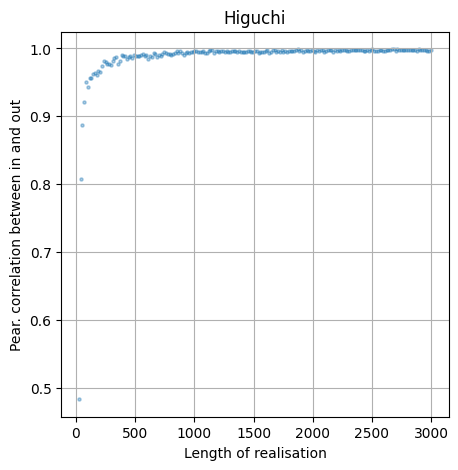

In [41]:

fig, ax = plt.subplots(1,figsize=(5,5))

ax.set_title('Higuchi')
ax.scatter(NN, Pearson_Correlations, s=5, alpha = 0.37)
ax.set_xlabel(f'Length of realisation')
ax.set_ylabel(f'Pear. correlation between in and out')
plt.grid()
fig.savefig('Pearson.png', format='png', dpi=800)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')